# Exploratory Analysis of the Ames dataset

In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', 500)

It is a good idea to define a variable for the base data directory, and to construct the exact filenames from that variable. Another good idea is to use the `pathlib` library for manipulating paths in Python, as it will make your code work in both Windows and Linux/MacOS.

In [2]:
DATA_DIR = pathlib.Path.cwd().parent / 'data'
print(DATA_DIR)

/home/fjayres/Dropbox/Insper/Disciplinas/MachineLearning/2023-1/sandbox/ames/data


## Analyzing the columns individually

Let's load the data from the previous section - this way we don't need to re-run all of the previous data adjusting:

In [3]:
processed_file_path = DATA_DIR / 'processed' / 'ames_with_correct_types.pkl'

with open(processed_file_path, 'rb') as file:
    (
        data,
        continuous_variables,
        discrete_variables,
        ordinal_variables,
        categorical_variables,
    ) = pickle.load(file)


### A first look at the categorical variables

               count unique      top  freq
Misc.Feature     106      5     Shed    95
Alley            198      2     Grvl   120
Garage.Type     2773      6   Attchd  1731
Mas.Vnr.Type    2907      5     None  1752
MS.SubClass     2930     16       20  1079
Central.Air     2930      2        Y  2734
Heating         2930      6     GasA  2885
Foundation      2930      6    PConc  1310
Exterior.2nd    2930     17  VinylSd  1015
Exterior.1st    2930     16  VinylSd  1026
Roof.Matl       2930      8  CompShg  2887
Roof.Style      2930      6    Gable  2321
House.Style     2930      8   1Story  1481
Bldg.Type       2930      5     1Fam  2425
Condition.2     2930      8     Norm  2900
Condition.1     2930      9     Norm  2522
Neighborhood    2930     28    NAmes   443
Lot.Config      2930      5   Inside  2140
Land.Contour    2930      4      Lvl  2633
Street          2930      2     Pave  2918
MS.Zoning       2930      7       RL  2273
Sale.Type       2930     10      WD   2536
Sale.Condit

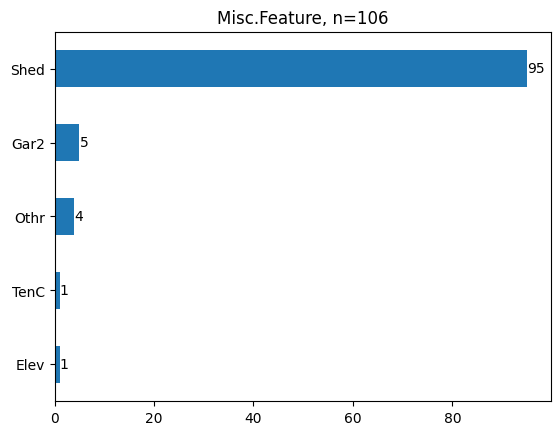

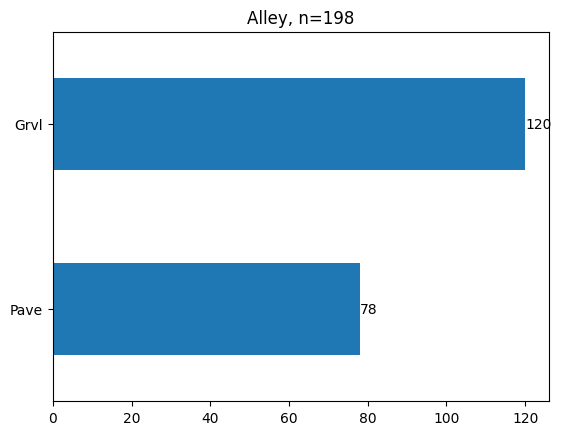

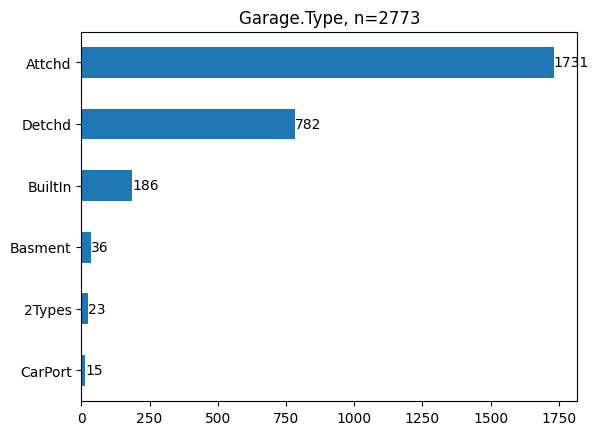

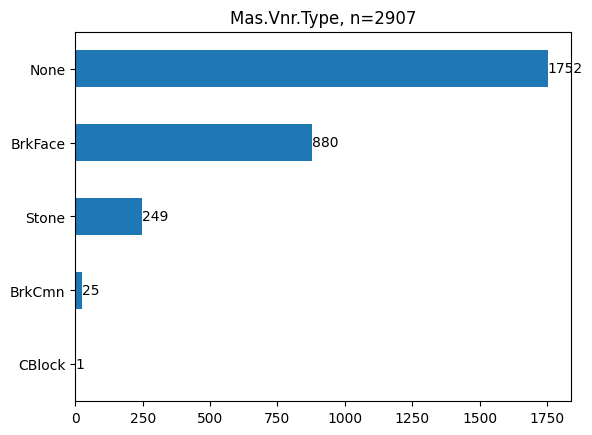

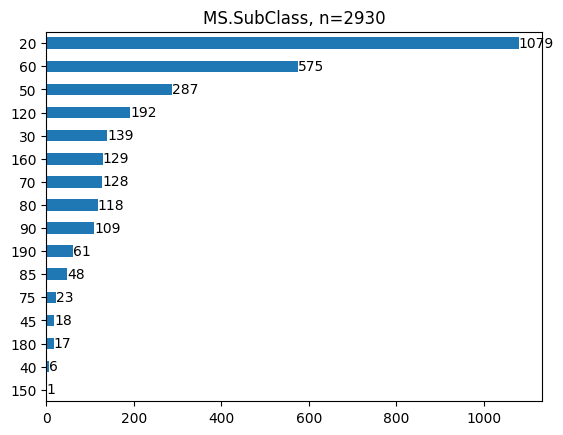

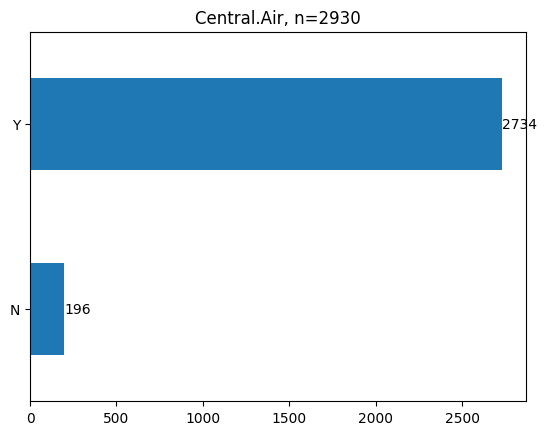

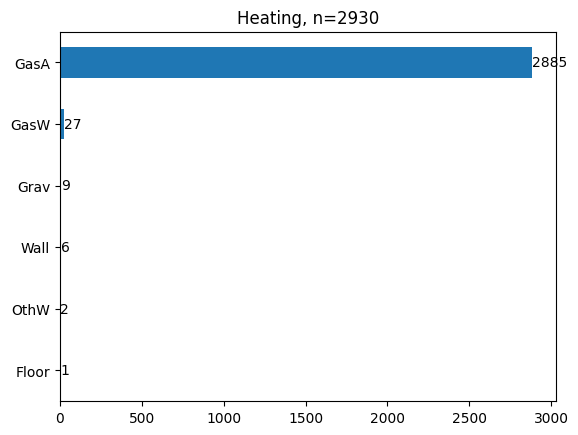

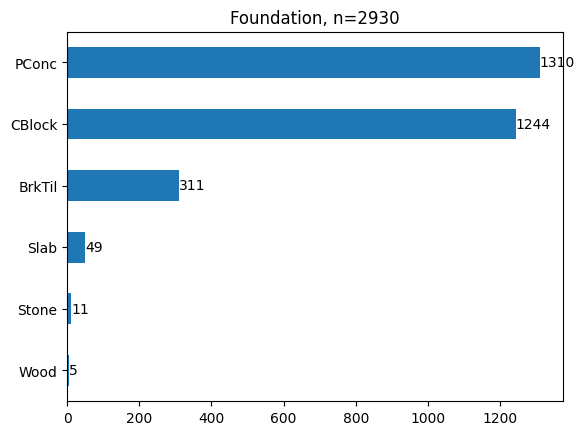

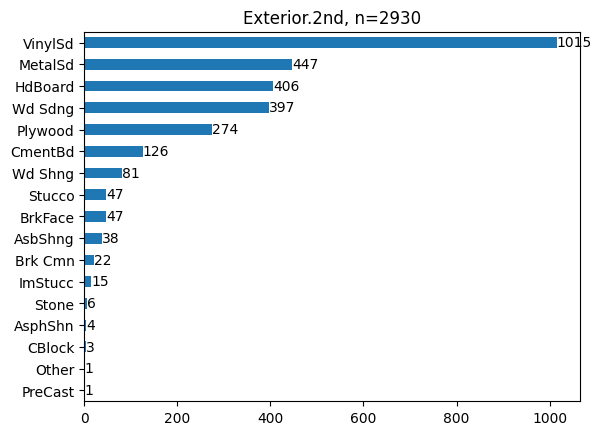

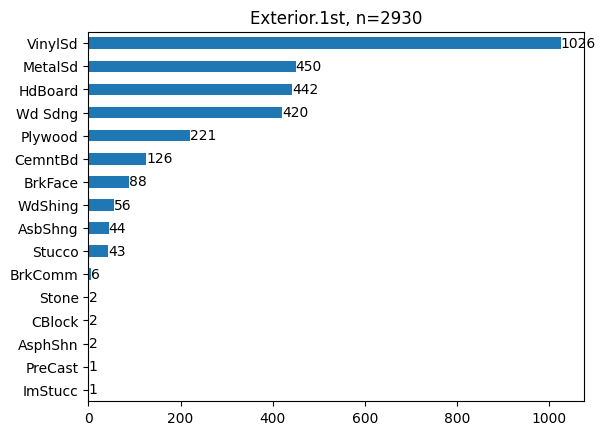

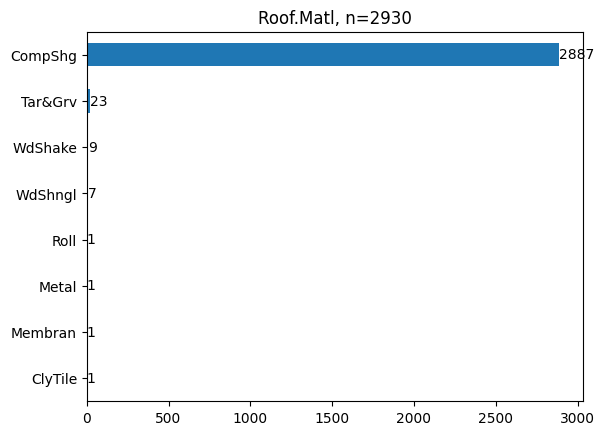

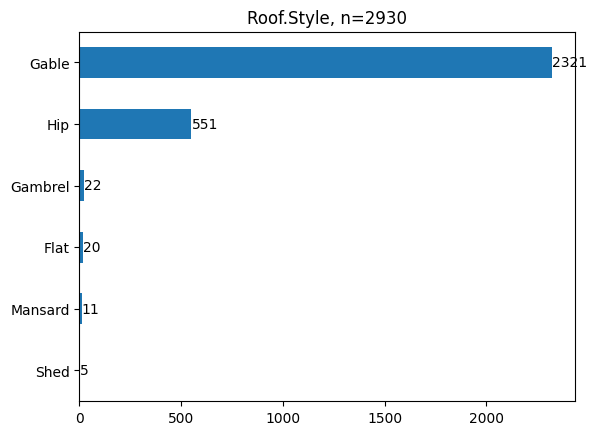

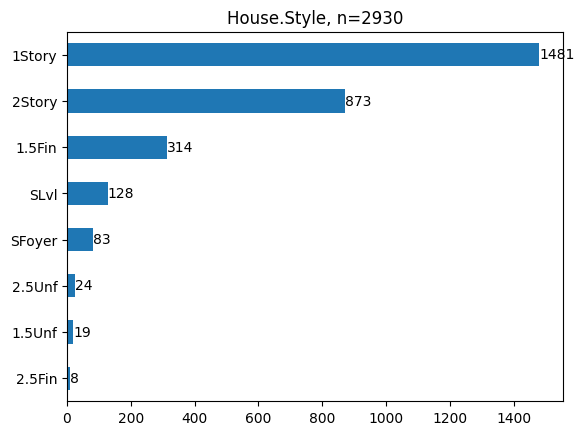

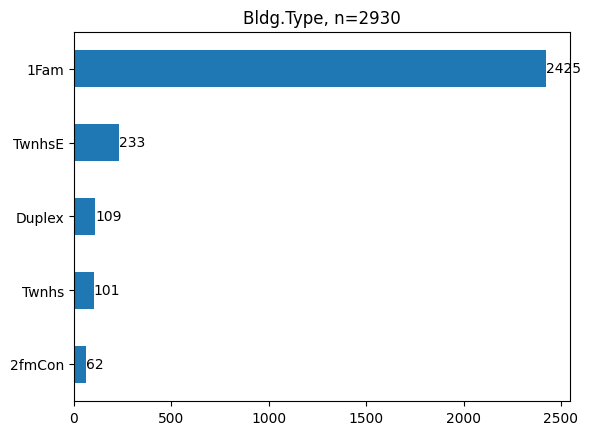

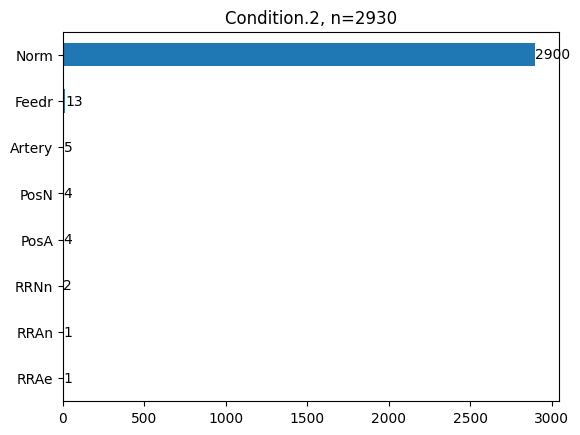

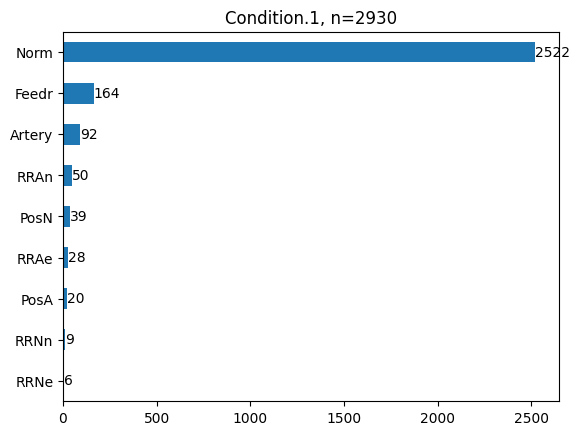

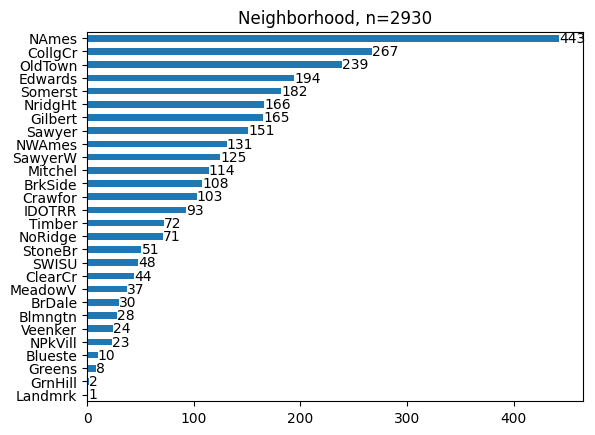

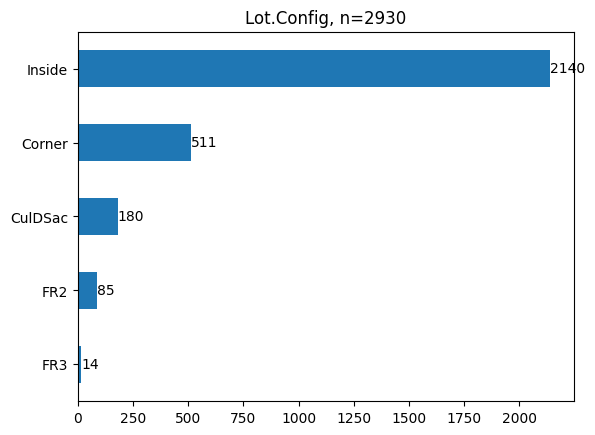

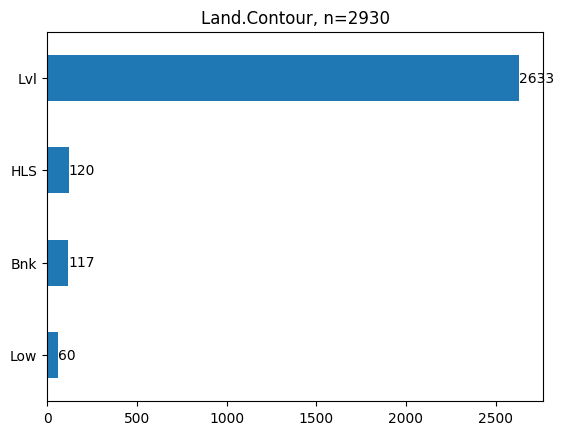

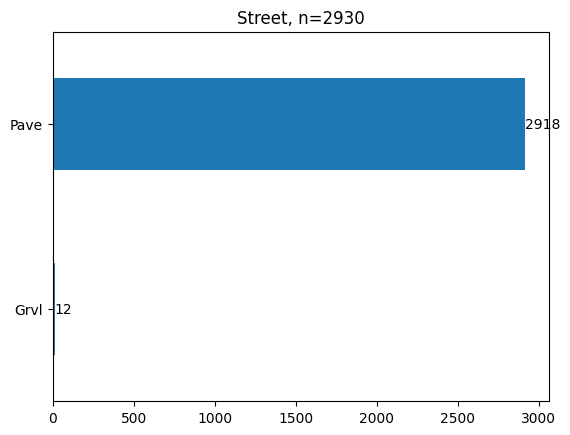

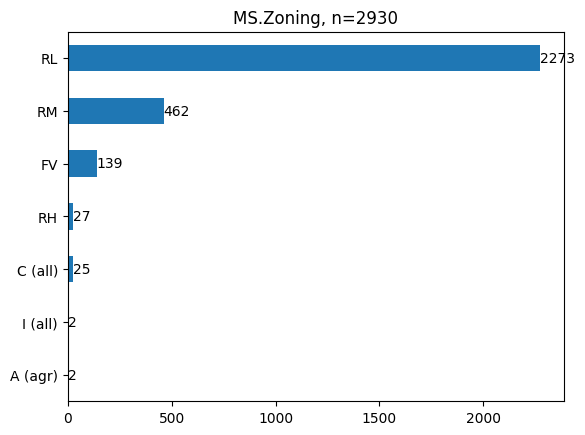

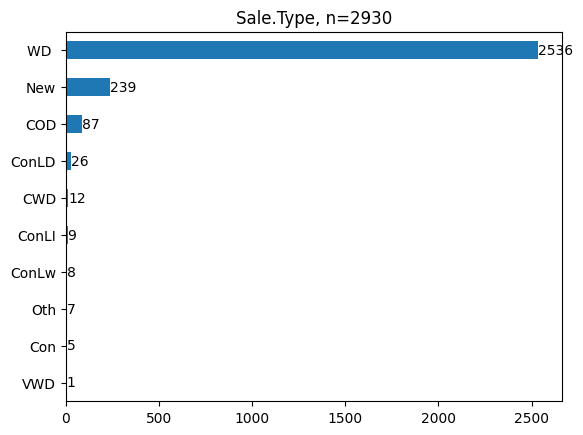

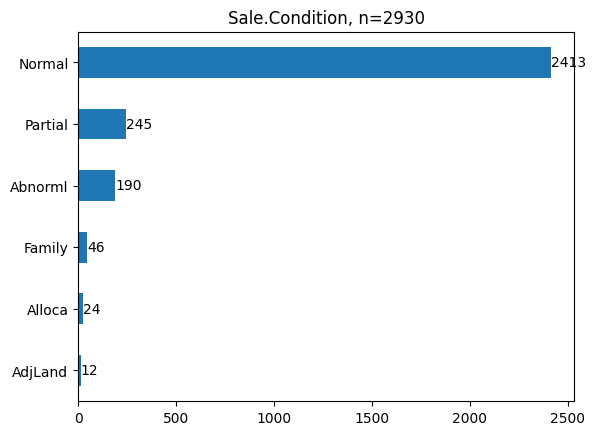

In [4]:
def plot_categoricals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        ax = data[col].value_counts().sort_values().plot.barh()
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_categoricals(data, categorical_variables)

It is important to notice:

- There are variables that have many categories with little representation. 
    - It may be interesting to remove the minor categories, and make a note that the model that we are developing is not suitable to process houses of these categories. 
    - Or we may decide to ignore columns of this nature altogether.
    - A third option is to group the minor categories into a new category named `Other`, to indicate that we are not ignoring these properties, but we don't have enough evidence to infer the effect of the precise minor categories into the sale price.
- Some variables contain a great number of missing values. 
    - It may be better to drop those columns,
    - or to assign all missing values to a newly created `Unknown` category



In order to simplify the data (CAREFUL: we may end up damaging the model here! If the future model is not performing well, it could be interesting to revisit these assumptions), we will process each variable, remove outliers, etc.

#### Residential zoning, sales types and conditions (`MS.Zoning`, `Sale.Type`, and `Sale.Condition`)

Lets concentrate first on residential sales types:

In [5]:
data['MS.Zoning'].unique()

['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)']
Categories (7, object): ['A (agr)', 'C (all)', 'FV', 'I (all)', 'RH', 'RL', 'RM']

In [6]:
data['MS.Zoning'].value_counts()

RL         2273
RM          462
FV          139
RH           27
C (all)      25
A (agr)       2
I (all)       2
Name: MS.Zoning, dtype: int64

We observe that a small number of sales are for non-residential properties, namely the categories `C (all)`, `A (agr)`, and `I (all)`. Let's remove them.

In [7]:
selection = ~(data['MS.Zoning'].isin(['A (agr)', 'C (all)', 'I (all)']))
selection.value_counts()

True     2901
False      29
Name: MS.Zoning, dtype: int64

So far, so good

In [8]:
data = data[selection]

Lets analyze the types of sale and condition. The documentation states:

```
Sale Type (Nominal): Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other
		
Sale Condition (Nominal): Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
```

Lets look at the representation of each category in the dataset.

In [9]:
data['Sale.Type'].value_counts()

WD       2513
New       239
COD        85
ConLD      22
CWD        12
ConLI       9
ConLw       8
Oth         7
Con         5
VWD         1
Name: Sale.Type, dtype: int64

In [10]:
data['Sale.Type'].unique()

['WD ', 'New', 'COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw', 'CWD', 'VWD']
Categories (10, object): ['COD', 'CWD', 'Con', 'ConLD', ..., 'New', 'Oth', 'VWD', 'WD ']

*AHA!* Careful with the name of the categories! The category `"WD "` has a space in it! Too many hours were spent debugging this kind of thing.

In [11]:
data['Sale.Condition'].value_counts()

Normal     2397
Partial     245
Abnorml     179
Family       46
Alloca       22
AdjLand      12
Name: Sale.Condition, dtype: int64

Upon careful analysis, looks like all types of sales and conditions are valid. But we need to be careful with the low representativity of some categories in both `Sale.Type` and `Sale.Condition`. Let's do some category reassigning:

- All warranty deed types will go into a `GroupedWD` category;
- Category `New` stays as-is.
- All the remaining minor categories go into an `Other` category.

In [12]:
processed_data = data.copy()

In [13]:
def remap_categories(
    series: pd.Series,
    old_categories: tuple[str],
    new_category: str,
) -> pd.Series:
    # Add the new category to the list of valid categories.
    series = series.cat.add_categories(new_category)

    # Set all items of the old categories as the new category.
    remapped_items = series.isin(old_categories)
    series.loc[remapped_items] = new_category

    # Clean up the list of categories, the old categories no longer exist.
    series = series.cat.remove_unused_categories()

    return series

In [14]:
processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('WD ', 'CWD', 'VWD'),
    new_category='GroupedWD',
)

processed_data['Sale.Type'] = remap_categories(
    series=processed_data['Sale.Type'],
    old_categories=('COD', 'ConLI', 'Con', 'ConLD', 'Oth', 'ConLw'),
    new_category='Other',
)

In [15]:
processed_data['Sale.Type'].value_counts()

GroupedWD    2526
New           239
Other         136
Name: Sale.Type, dtype: int64

Much better!

In [16]:
data = processed_data

#### Street paving (`Street`)

Now lets focus on street paving (`Street`):

In [17]:
data['Street'].value_counts()

Pave    2895
Grvl       6
Name: Street, dtype: int64

The very low representativity of the minor class `Grvl` forces us to ignore this column altogether:

In [18]:
data = data.drop(columns='Street')

#### House surroundings (`Condition.1` and `Condition.2`)

Let's check for conditions (`Condition.1` and `Condition.2`) pertaining to the house surroundings:

In [19]:
data['Condition.1'].value_counts()

Norm      2500
Feedr      158
Artery      91
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition.1, dtype: int64

In [20]:
data['Condition.2'].value_counts()

Norm      2872
Feedr       12
Artery       5
PosA         4
PosN         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition.2, dtype: int64

In [21]:
pd.crosstab(data['Condition.1'], data['Condition.2'])

Condition.2,Artery,Feedr,Norm,PosA,PosN,RRAe,RRAn,RRNn
Condition.1,,,,,,,,
Artery,2,0,88,1,0,0,0,0
Feedr,1,3,150,0,0,1,1,2
Norm,0,0,2500,0,0,0,0,0
PosA,0,0,17,3,0,0,0,0
PosN,0,0,35,0,4,0,0,0
RRAe,0,0,28,0,0,0,0,0
RRAn,1,8,41,0,0,0,0,0
RRNe,0,0,6,0,0,0,0,0
RRNn,1,1,7,0,0,0,0,0


Again, we observe very low representation of the minor classes. Lets reassign some categories to group similar features:

- The railroad proximity categories (`RRAn`, `RRAe`, `RRNn`, and `RRNe`) will go into a single `Railroad` category;
- The `Feedr` and `Artery` categories refer to larger streets that collect traffic from local streets and connect neighborhoods (e.g. large avenues), lets place them into a `Roads` category;
- The `PosA` and `PosN` refer to positive features adjacent or nearby the building, lets place them into a `Positive` category.

In [22]:
processed_data = data.copy()

In [23]:
for col in ('Condition.1', 'Condition.2'):
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('RRAn', 'RRAe', 'RRNn', 'RRNe'),
        new_category='Railroad',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('Feedr', 'Artery'),
        new_category='Roads',
    )
    processed_data[col] = remap_categories(
        series=processed_data[col],
        old_categories=('PosA', 'PosN'),
        new_category='Positive',
    )

In [24]:
processed_data['Condition.1'].value_counts()

Norm        2500
Roads        249
Railroad      93
Positive      59
Name: Condition.1, dtype: int64

In [25]:
processed_data['Condition.2'].value_counts()

Norm        2872
Roads         17
Positive       8
Railroad       4
Name: Condition.2, dtype: int64

In [26]:
pd.crosstab(processed_data['Condition.1'], processed_data['Condition.2'])

Condition.2,Norm,Railroad,Roads,Positive
Condition.1,,,,
Norm,2500,0,0,0
Railroad,82,0,11,0
Roads,238,4,6,1
Positive,52,0,0,7


Looks like we can recombine the `Condition.1` and `Condition.2` columns into a single categorical column with the categories:

- `Norm`: `Condition.1` is `Norm`;
- `Railroad`: `Condition.1` is `Railroad` and `Condition.2` is `Norm`;
- `Roads`: `Condition.1` is `Roads` and `Condition.2` is not `Railroad`;
- `Positive`: `Condition.1` is `Positive`;
- `RoadsAndRailroad`: (`Condition.1` is `Railroad` and `Condition.2` is `Roads`) or (`Condition.1` is `Roads` and `Condition.2` is `Railroad`).

In [27]:
processed_data['Condition'] = pd.Series(
    index=processed_data.index,
    dtype=pd.CategoricalDtype(categories=(
        'Norm',
        'Railroad',
        'Roads',
        'Positive',
        'RoadsAndRailroad',
    )),
)

In [28]:
norm_items = processed_data['Condition.1'] == 'Norm'
processed_data['Condition'][norm_items] = 'Norm'

In [29]:
railroad_items = (processed_data['Condition.1'] == 'Railroad') \
    & (processed_data['Condition.2'] == 'Norm')
processed_data['Condition'][railroad_items] = 'Railroad'

In [30]:
roads_items = (processed_data['Condition.1'] == 'Roads') \
    & (processed_data['Condition.2'] != 'Railroad')
processed_data['Condition'][roads_items] = 'Roads'

In [31]:
positive_items = processed_data['Condition.1'] == 'Positive'
processed_data['Condition'][positive_items] = 'Positive'

In [32]:
roads_and_railroad_items = \
    ( \
        (processed_data['Condition.1'] == 'Railroad') \
        & (processed_data['Condition.2'] == 'Roads')
    ) \
    | ( \
        (processed_data['Condition.1'] == 'Roads') \
        & (processed_data['Condition.2'] == 'Railroad') \
    )
processed_data['Condition'][roads_and_railroad_items] = 'RoadsAndRailroad'

In [33]:
processed_data['Condition'].value_counts()

Norm                2500
Roads                245
Railroad              82
Positive              59
RoadsAndRailroad      15
Name: Condition, dtype: int64

There is no apparent need, for now, to go into further simplification of this variable. Lets drop the original variables:

In [34]:
processed_data = processed_data.drop(columns=['Condition.1', 'Condition.2'])

In [35]:
data = processed_data

#### Columns with many missing values (`Misc.Feature` and `Alley`)

The columns `Misc.Feature` and `Alley` are mostly formed by missing values!

             count unique   top freq
Misc.Feature   104      5  Shed   93
Alley          195      2  Grvl  119


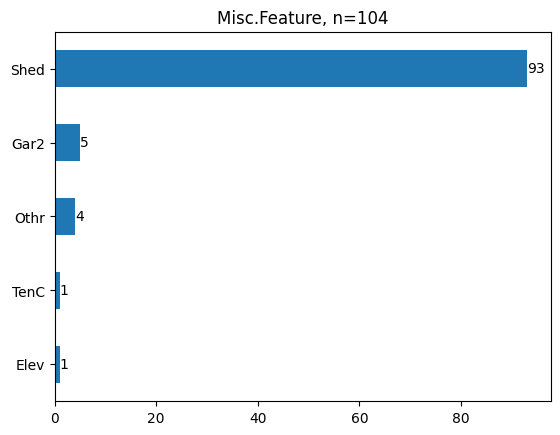

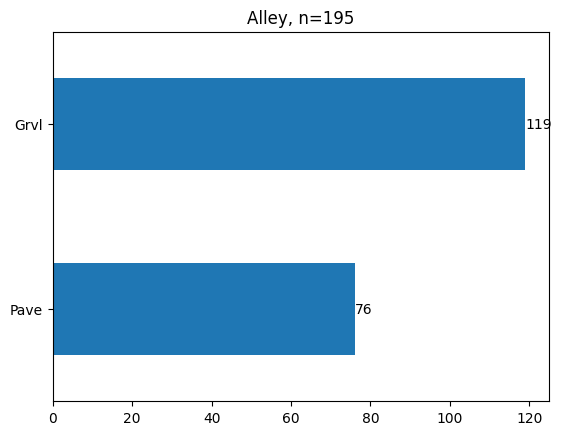

In [36]:
plot_categoricals(data, ['Misc.Feature', 'Alley'])

But it looks like we can reuse this information, still. We can transform the `Misc.Feature` variable into a `HasShed` variable that indicates whether the house has a shed:

In [37]:
data['HasShed'] = data['Misc.Feature'] == 'Shed'
data = data.drop(columns='Misc.Feature')

In [38]:
data['HasShed'].value_counts()

False    2808
True       93
Name: HasShed, dtype: int64

Likewise, we can mutate the `Alley` feature into a `HasAlley` feature:

In [39]:
data['HasAlley'] = ~data['Alley'].isna()
data = data.drop(columns='Alley')

In [40]:
data['HasAlley'].value_counts()

False    2706
True      195
Name: HasAlley, dtype: int64

#### Exterior coverings (`Exterior.1st` and `Exterior.2nd`)

The exterior coverings have a lot of categories, some with very low representativity:

             count unique      top  freq
Exterior.1st  2901     16  VinylSd  1025
Exterior.2nd  2901     17  VinylSd  1012


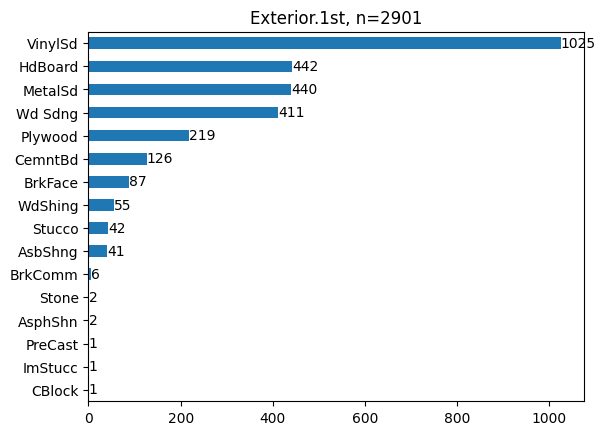

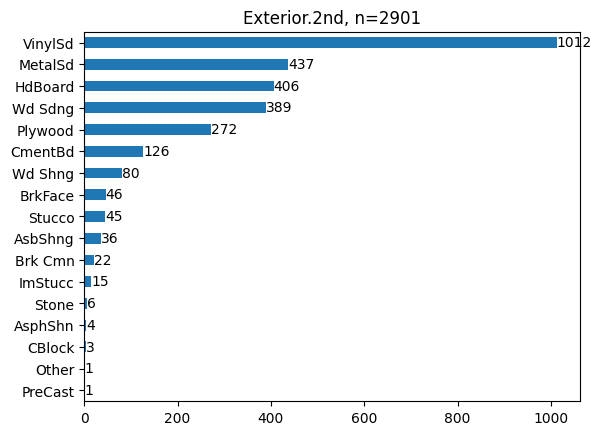

In [41]:
plot_categoricals(data, ['Exterior.1st', 'Exterior.2nd'])

Also, it looks like there are a few typos!


| `Exterior.1st` | `Exterior.2nd` | `Correct value` |
|----------------|----------------|-----------------|
| `BrkComm`      | `Brk Cmn`      | `BrkComm`       |
| `CemntBd`      | `CmentBd`      | `CemntBd`       |
| `WdShing`      | `Wd Shng`      | `WdShing`       |

Lets fix those

In [42]:
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Brk Cmn', ),
    new_category='BrkComm',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('CmentBd', ),
    new_category='CemntBd',
)
data['Exterior.2nd'] = remap_categories(
    series=data['Exterior.2nd'],
    old_categories=('Wd Shng', ),
    new_category='WdShing',
)


In [43]:
for col in ('Exterior.1st', 'Exterior.2nd'):
    categories = data[col].cat.categories
    data[col] = data[col].cat.reorder_categories(sorted(categories))

In [44]:
pd.crosstab(data['Exterior.1st'], data['Exterior.2nd'])

Exterior.2nd,AsbShng,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Other,Plywood,PreCast,Stone,Stucco,VinylSd,Wd Sdng,WdShing
Exterior.1st,,,,,,,,,,,,,,,,,
AsbShng,33,0,0,0,0,1,0,0,0,0,5,0,0,1,0,1,0
AsphShn,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BrkComm,0,0,4,0,0,0,0,0,0,0,0,0,0,1,0,1,0
BrkFace,1,0,0,43,0,0,3,0,3,0,8,0,3,3,1,21,1
CBlock,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
CemntBd,0,0,0,0,0,124,0,0,0,0,0,0,0,0,0,1,1
HdBoard,0,1,0,1,0,0,383,6,1,0,41,0,0,1,0,3,5
ImStucc,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
MetalSd,0,1,0,0,1,0,3,0,427,0,0,0,0,3,2,2,1


It looks like there are a few popular options and lots of poorly represented materials beyond the popular ones. Due to lack of representativity, lets keep only the popular categories as-is, and group the rest into an `Other` category.

Also, looks like it is often the case that the first material is the same as the second material, probably to indicate that the house exterior contains only one material. Therefore, we will keep only the `Exterior.1st` variable.

In [45]:
processed_data = data.copy()

In [46]:
mat_count = processed_data['Exterior.1st'].value_counts()
mat_count

VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
BrkComm       6
AsphShn       2
Stone         2
CBlock        1
ImStucc       1
PreCast       1
Name: Exterior.1st, dtype: int64

In [47]:
rare_materials = list(mat_count[mat_count < 40].index)
rare_materials

['BrkComm', 'AsphShn', 'Stone', 'CBlock', 'ImStucc', 'PreCast']

In [48]:
processed_data['Exterior'] = remap_categories(
    series=processed_data['Exterior.1st'],
    old_categories=rare_materials,
    new_category='Other',
)
processed_data = processed_data.drop(columns=['Exterior.1st', 'Exterior.2nd'])

In [49]:
processed_data['Exterior'].value_counts()

VinylSd    1025
HdBoard     442
MetalSd     440
Wd Sdng     411
Plywood     219
CemntBd     126
BrkFace      87
WdShing      55
Stucco       42
AsbShng      41
Other        13
Name: Exterior, dtype: int64

In [50]:
data = processed_data

#### `Heating`

        count unique   top  freq
Heating  2901      6  GasA  2859


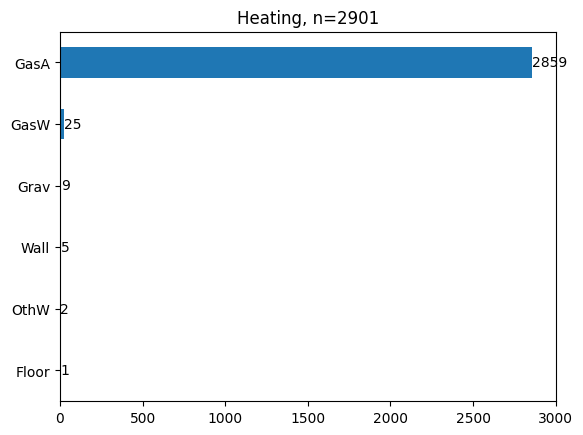

In [51]:
plot_categoricals(data, ['Heating',])

This column does not have missing values, and an overwhelming amount of items belong to the same category. As such, there is not much information here, lets discard the column.

In [52]:
data = data.drop(columns='Heating')

#### `Roof.Matl` and `Roof.Style`

           count unique      top  freq
Roof.Matl   2901      8  CompShg  2858
Roof.Style  2901      6    Gable  2301


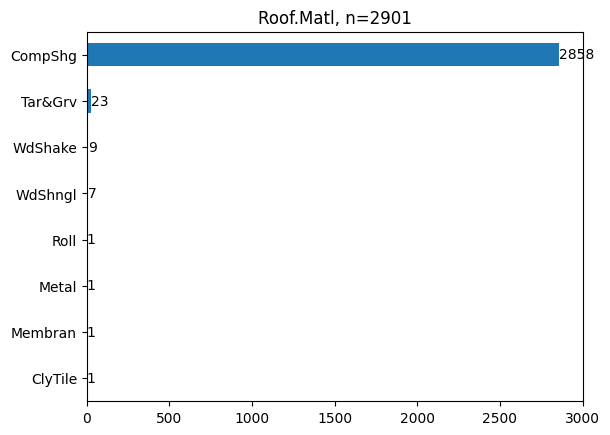

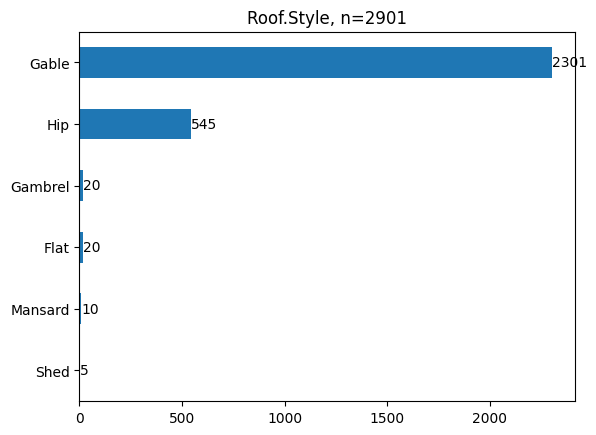

In [53]:
plot_categoricals(data, ['Roof.Matl', 'Roof.Style'])

Due to the low representativity of the minor categories in the `Roof.Matl` feature, we will drop it.

In [54]:
data = data.drop(columns='Roof.Matl')

In the `Roof.Style` feature we have two substantial categories, and a few very minor ones. Lets group the minor categories into an `Other` category:

In [55]:
data['Roof.Style'] = remap_categories(
    series=data['Roof.Style'],
    old_categories=[
        'Flat',
        'Gambrel',
        'Mansard',
        'Shed',
    ],
    new_category='Other',
)

In [56]:
data['Roof.Style'].value_counts()

Gable    2301
Hip       545
Other      55
Name: Roof.Style, dtype: int64

#### `Mas.Vnr.Type`

In [57]:
data['Mas.Vnr.Type'].value_counts()

None       1723
BrkFace     880
Stone       249
BrkCmn       25
CBlock        1
Name: Mas.Vnr.Type, dtype: int64

Lets group the two minor classes into an `Other` class:

In [58]:
data['Mas.Vnr.Type'] = remap_categories(
    series=data['Mas.Vnr.Type'],
    old_categories=[
        'BrkCmn',
        'CBlock',
    ],
    new_category='Other',
)

In [59]:
data['Mas.Vnr.Type'].value_counts()

None       1723
BrkFace     880
Stone       249
Other        26
Name: Mas.Vnr.Type, dtype: int64

#### `MS.SubClass`

             count  unique  top  freq
MS.SubClass   2901      16   20  1074


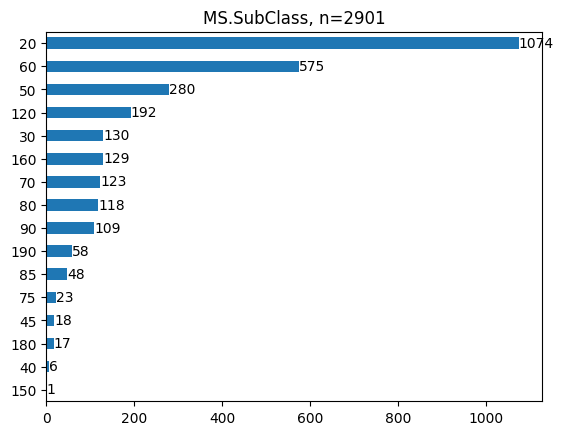

In [60]:
plot_categoricals(data, ['MS.SubClass'])

This is a complicated feature, lets look at the documentation:

```
MS SubClass (Nominal): Identifies the type of dwelling involved in the sale.	

       020	1-STORY 1946 & NEWER ALL STYLES
       030	1-STORY 1945 & OLDER
       040	1-STORY W/FINISHED ATTIC ALL AGES
       045	1-1/2 STORY - UNFINISHED ALL AGES
       050	1-1/2 STORY FINISHED ALL AGES
       060	2-STORY 1946 & NEWER
       070	2-STORY 1945 & OLDER
       075	2-1/2 STORY ALL AGES
       080	SPLIT OR MULTI-LEVEL
       085	SPLIT FOYER
       090	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES
```

This is the moment where you reach out to a real-estate agent and ask what is the meaning of these categories, and whether they can they be meaningfully grouped together. For now lets just reassign the minor categories to an `Other` category:

In [61]:
data['MS.SubClass'] = remap_categories(
    series=data['MS.SubClass'],
    old_categories=[75, 45, 180, 40, 150],
    new_category='Other',
)

In [62]:
data['MS.SubClass'].value_counts()

20       1074
60        575
50        280
120       192
30        130
160       129
70        123
80        118
90        109
Other      65
190        58
85         48
Name: MS.SubClass, dtype: int64

#### `Foundation`

           count unique    top  freq
Foundation  2901      6  PConc  1308


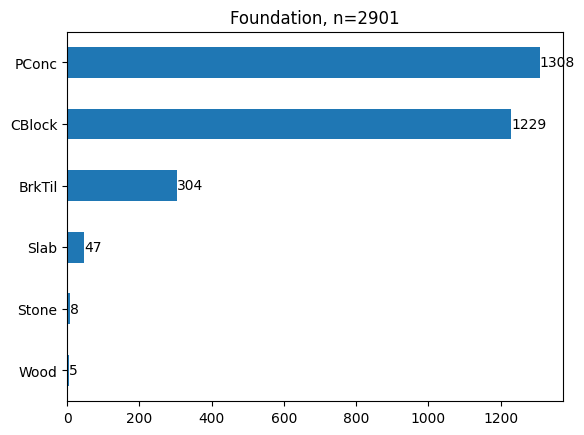

In [63]:
plot_categoricals(data, ['Foundation'])

Same story: minor categories grouped into an `Other` category.

In [64]:
data['Foundation'] = remap_categories(
    series=data['Foundation'],
    old_categories=['Slab', 'Stone', 'Wood'],
    new_category='Other',
)

#### `Neighborhood`

In [65]:
data['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64

We can either group the minor categories into an `Other` category, or drop the rows. Both approaches have their pros and cons:

- If we delete the rows we are being more precise, in the sense that we restrict our model to fewer neighborhoods.
- If we mantain the rows we have more data to construct the model.

Lets drop the rows and make a note that this model does not work for those neighborhoods.

In [66]:
selection = ~data['Neighborhood'].isin([
    'Blueste',
    'Greens',
    'GrnHill',
    'Landmrk',
])
data = data[selection]

In [67]:
data['Neighborhood'] = data['Neighborhood'].cat.remove_unused_categories()

In [68]:
data['Neighborhood'].value_counts()

NAmes      443
CollgCr    267
OldTown    237
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    113
BrkSide    108
Crawfor    103
Timber      72
NoRidge     71
IDOTRR      68
StoneBr     51
SWISU       47
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Name: Neighborhood, dtype: int64

### A final look at the categorical variables

After all of this processing, even the set of categorical variables has changed, so lets make a new list:

In [69]:
all_discrete = data.select_dtypes('category').columns

new_categorical_variables = [col for col in all_discrete \
                         if not col in ordinal_variables]

In [70]:
ordinal_variables

['Lot.Shape',
 'Utilities',
 'Land.Slope',
 'Overall.Qual',
 'Overall.Cond',
 'Exter.Qual',
 'Exter.Cond',
 'Bsmt.Qual',
 'Bsmt.Cond',
 'Bsmt.Exposure',
 'BsmtFin.Type.1',
 'BsmtFin.Type.2',
 'Heating.QC',
 'Electrical',
 'Kitchen.Qual',
 'Functional',
 'Fireplace.Qu',
 'Garage.Finish',
 'Garage.Qual',
 'Garage.Cond',
 'Paved.Drive',
 'Pool.QC',
 'Fence']

               count unique        top  freq
Garage.Type     2733      6     Attchd  1714
Mas.Vnr.Type    2857      4       None  1703
MS.SubClass     2880     12         20  1074
MS.Zoning       2880      4         RL  2265
Land.Contour    2880      4        Lvl  2594
Lot.Config      2880      5     Inside  2103
Neighborhood    2880     24      NAmes   443
Bldg.Type       2880      5       1Fam  2399
House.Style     2880      8     1Story  1454
Roof.Style      2880      3      Gable  2280
Foundation      2880      4      PConc  1306
Central.Air     2880      2          Y  2702
Sale.Type       2880      3  GroupedWD  2506
Sale.Condition  2880      6     Normal  2376
Condition       2880      5       Norm  2479
Exterior        2880     11    VinylSd  1024


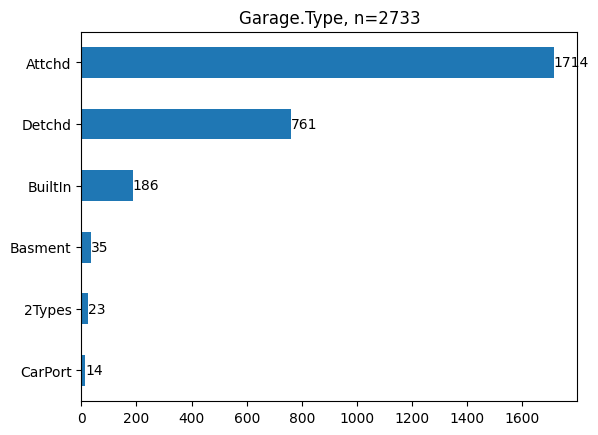

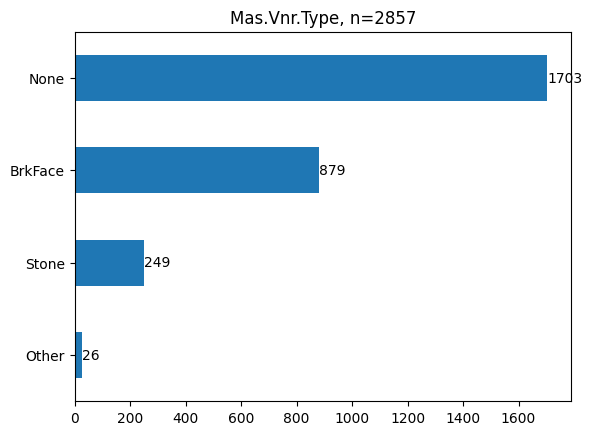

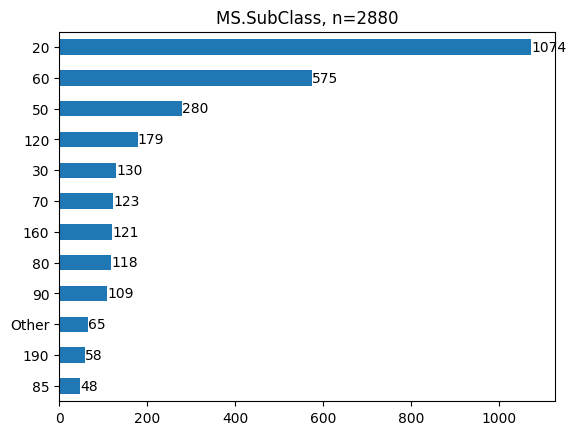

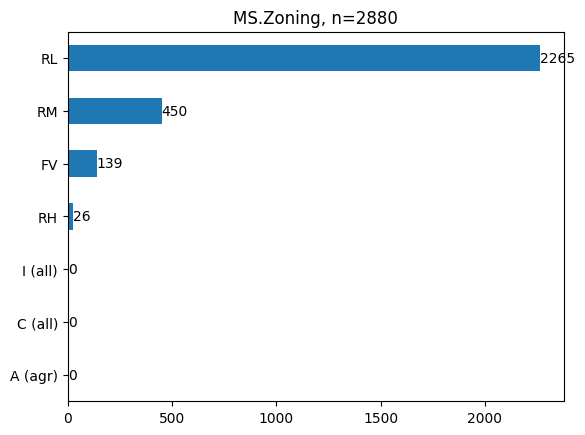

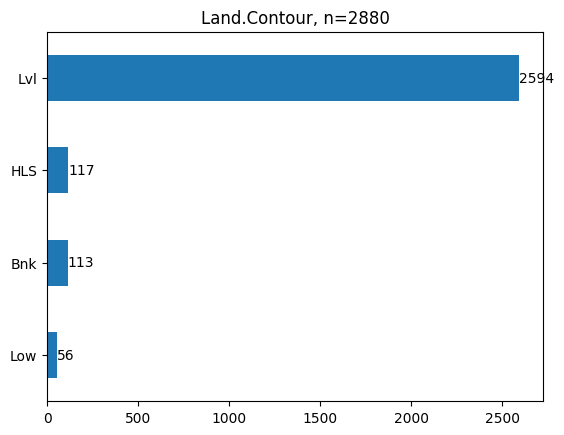

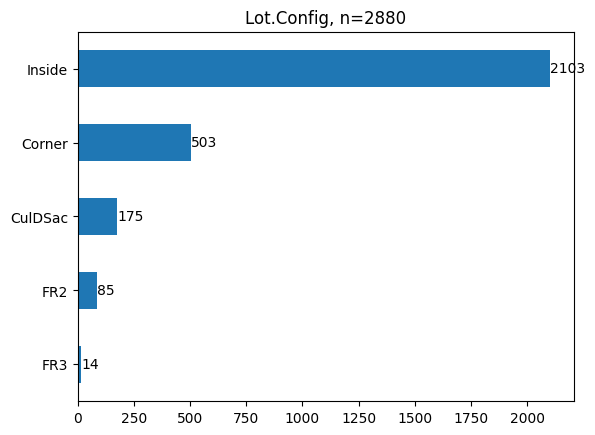

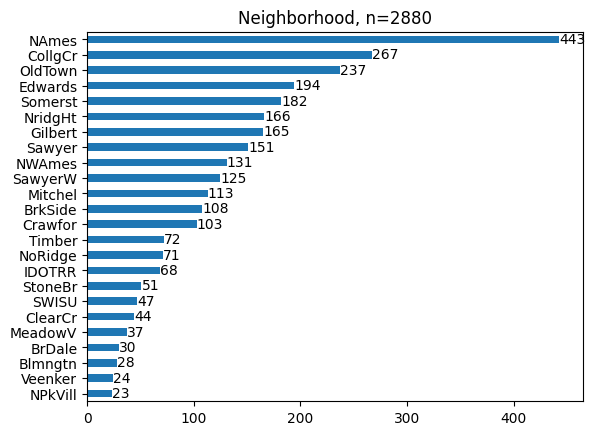

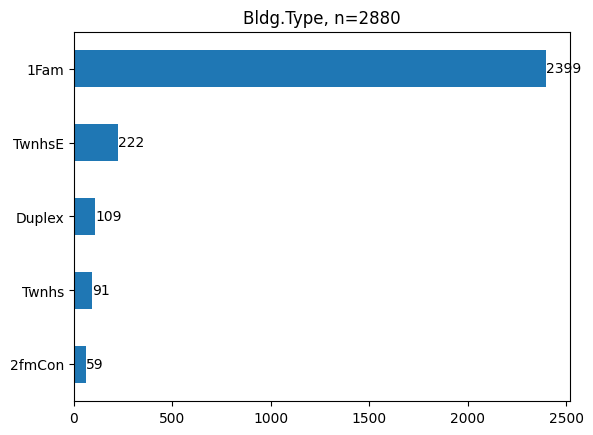

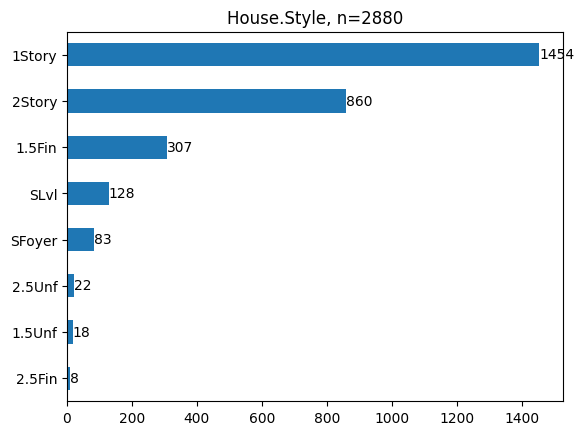

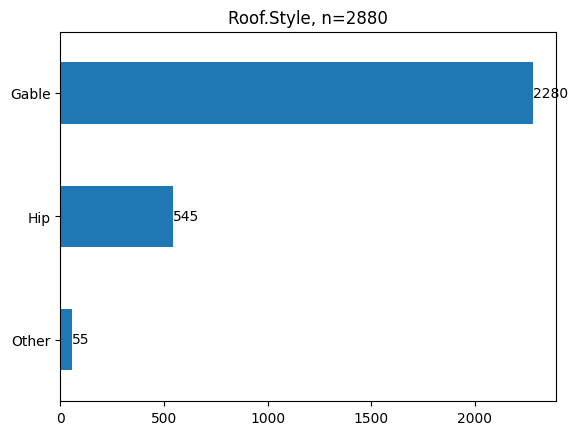

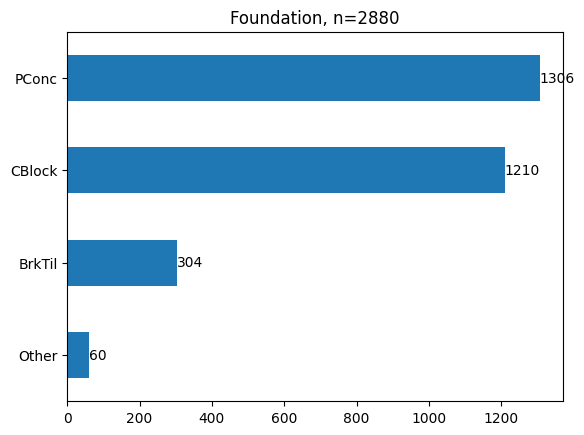

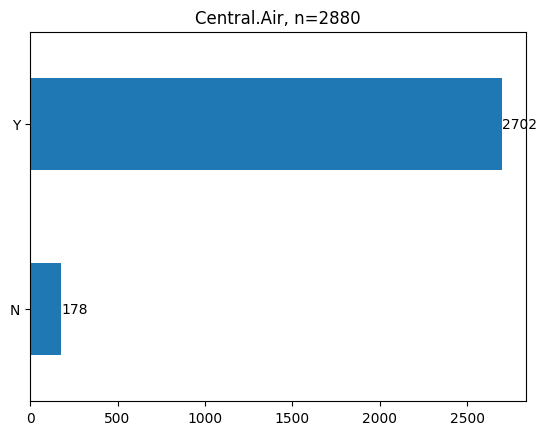

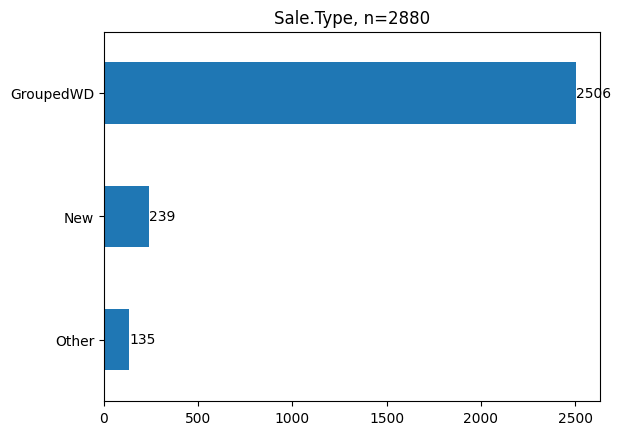

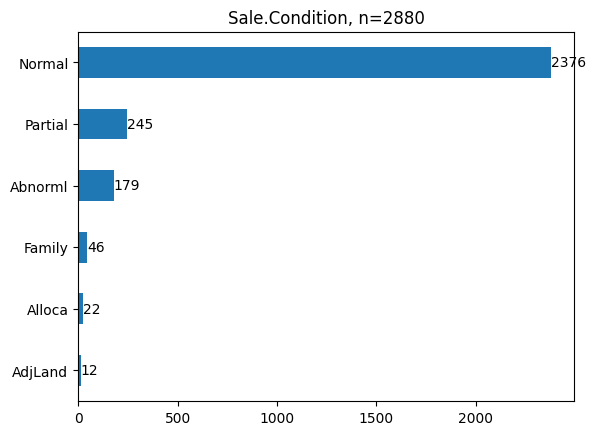

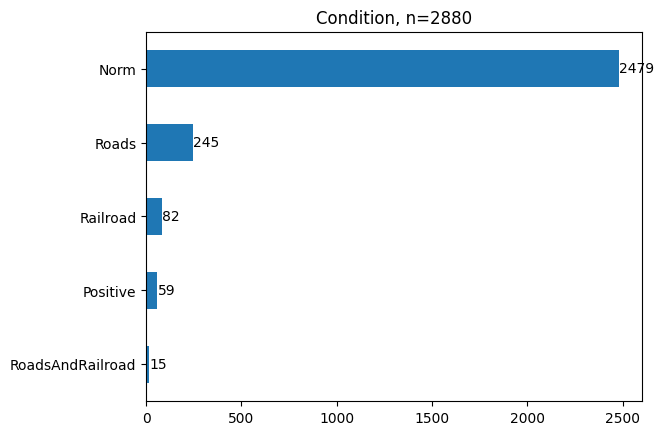

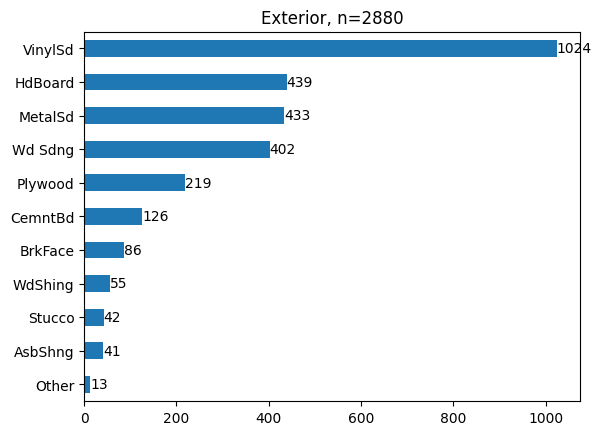

In [71]:
plot_categoricals(data, new_categorical_variables)

Looks like we are done with the categorical variables, yay!

### Analyzing the continuous variables

Lets look for anomalies, outliers, and all sorts of things that may hinder our modeling.

                  count           mean           std      min        25%  \
Lot.Frontage     2397.0      69.472257     23.261537     21.0      59.00   
Garage.Yr.Blt    2731.0    1978.341633     25.388716   1900.0    1960.00   
Mas.Vnr.Area     2857.0     103.596430    180.153725      0.0       0.00   
Bsmt.Full.Bath   2878.0       0.433634      0.525612      0.0       0.00   
Bsmt.Half.Bath   2878.0       0.061849      0.246625      0.0       0.00   
Garage.Cars      2879.0       1.774575      0.757336      0.0       1.00   
BsmtFin.SF.1     2879.0     444.993053    456.336521      0.0       0.00   
BsmtFin.SF.2     2879.0      50.041334    169.929207      0.0       0.00   
Bsmt.Unf.SF      2879.0     562.549844    440.582493      0.0     222.00   
Total.Bsmt.SF    2879.0    1057.584231    439.306589      0.0     796.00   
Garage.Area      2879.0     474.925669    214.001822      0.0     325.50   
Full.Bath        2880.0       1.573958      0.552316      0.0       1.00   
Half.Bath   

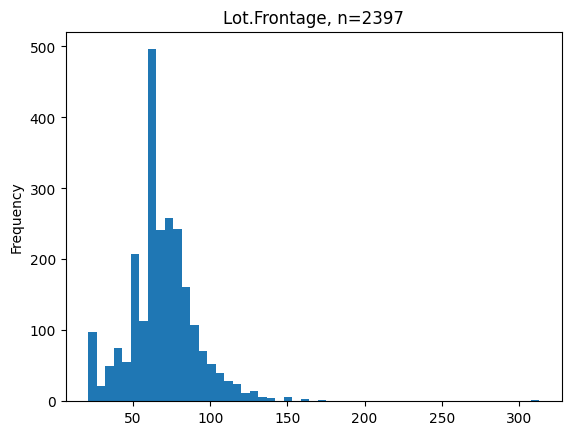

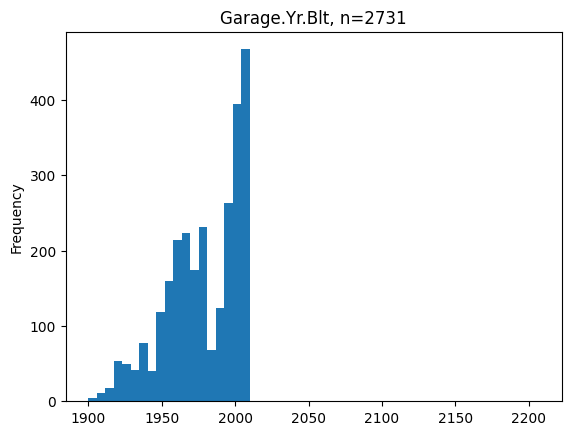

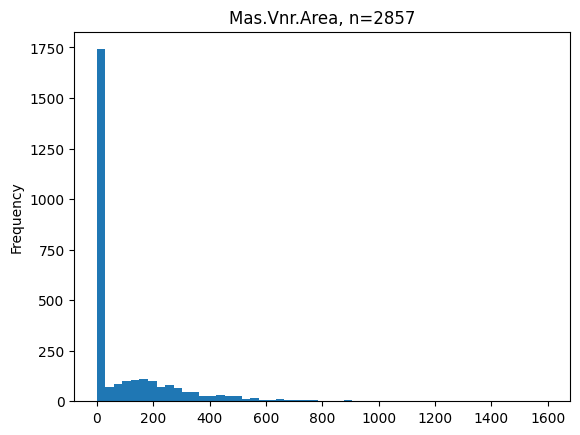

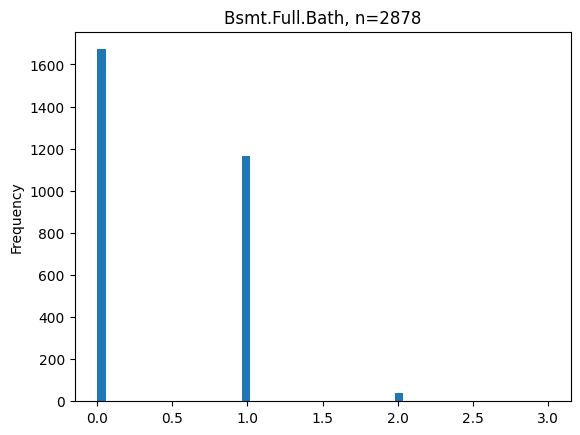

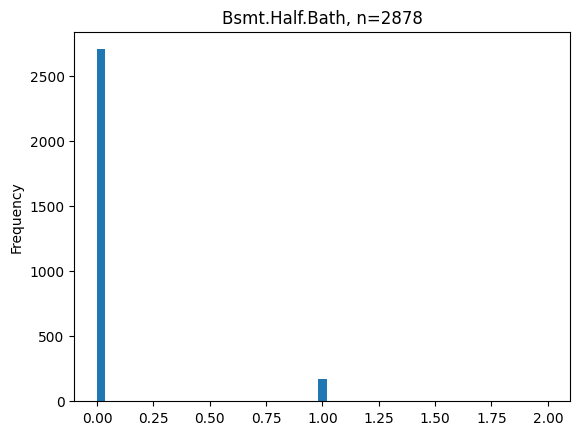

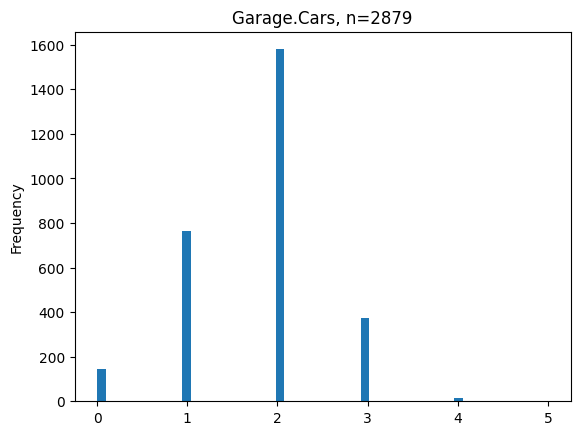

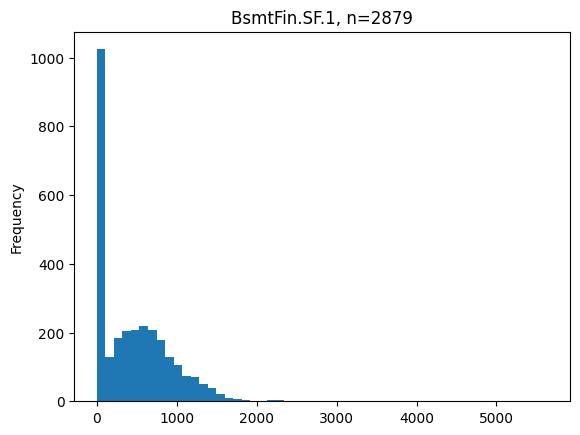

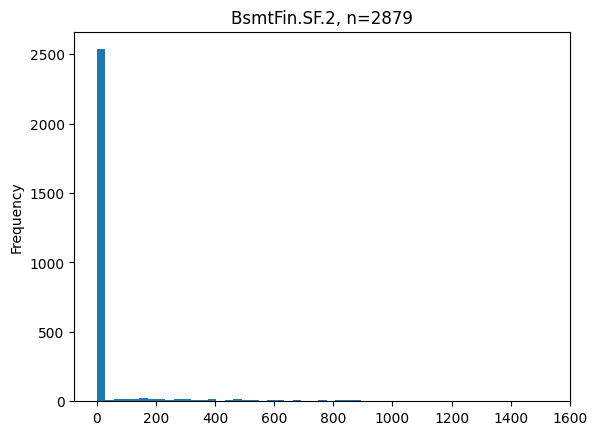

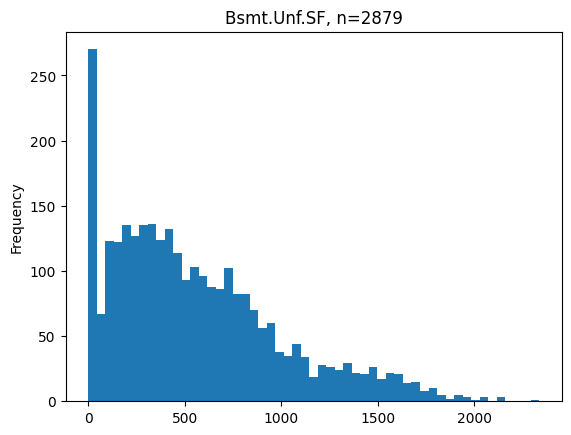

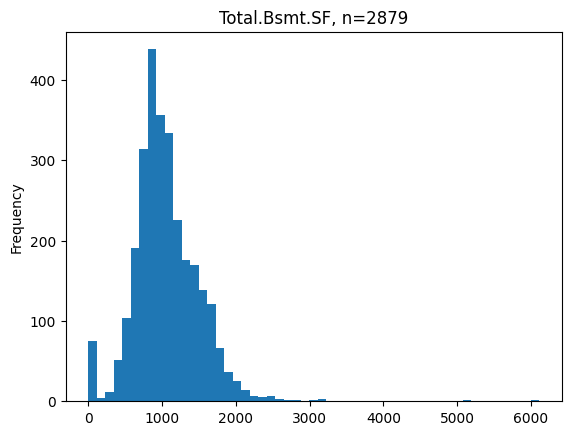

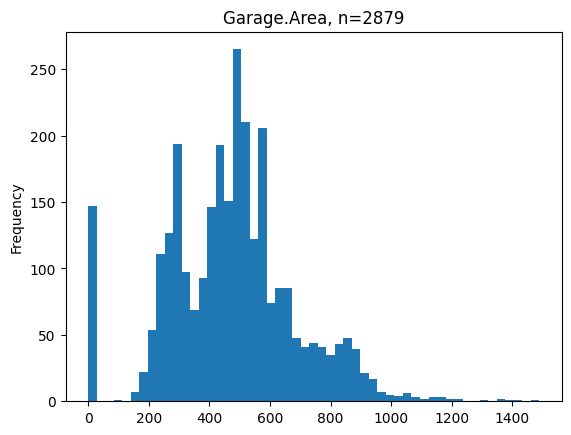

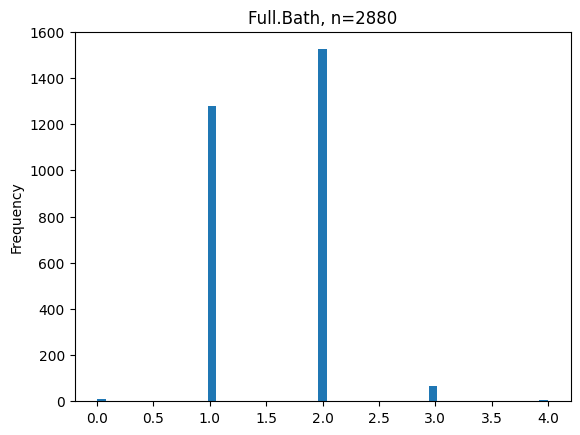

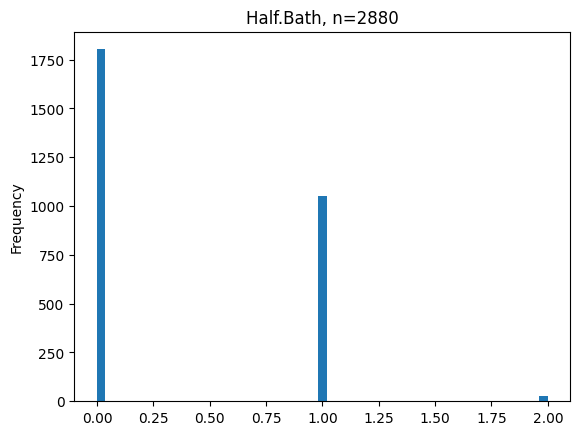

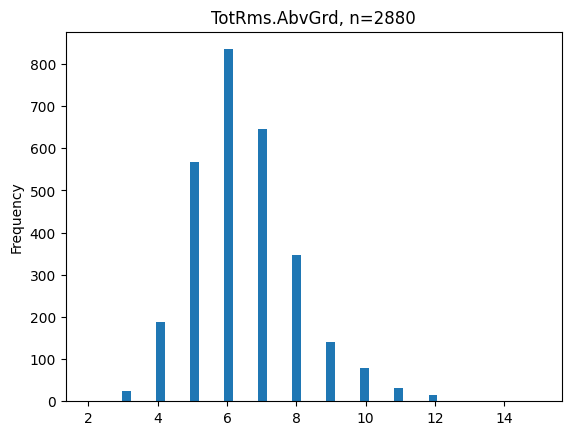

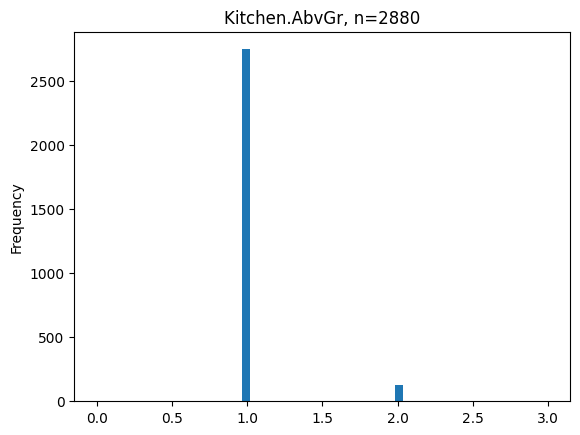

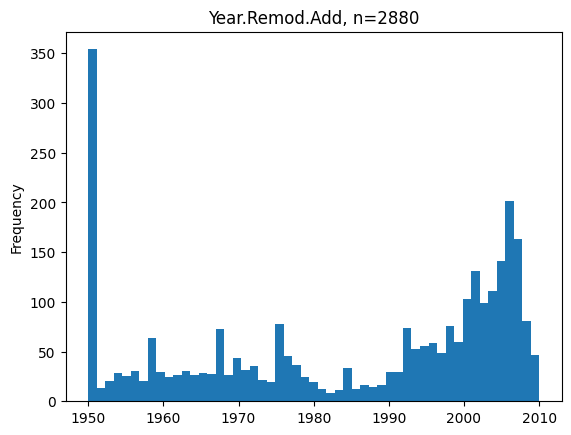

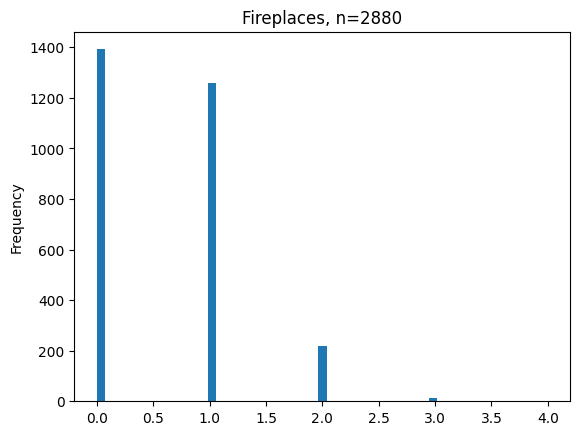

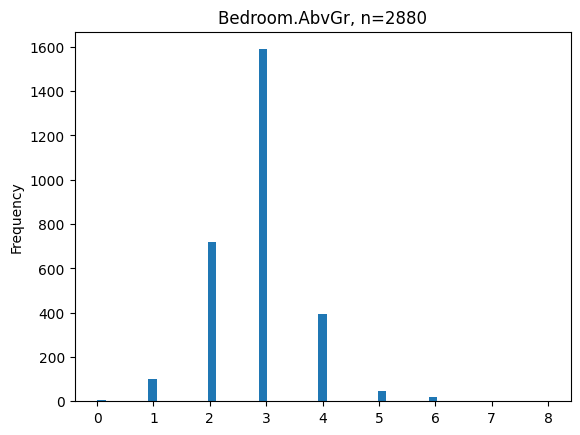

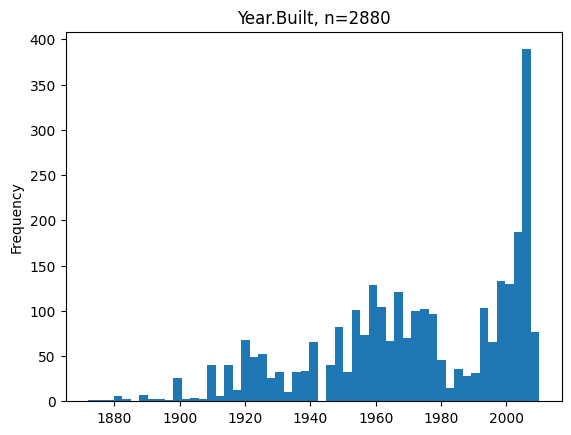

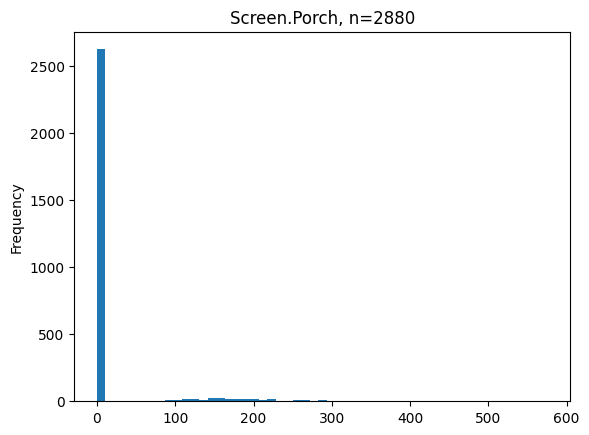

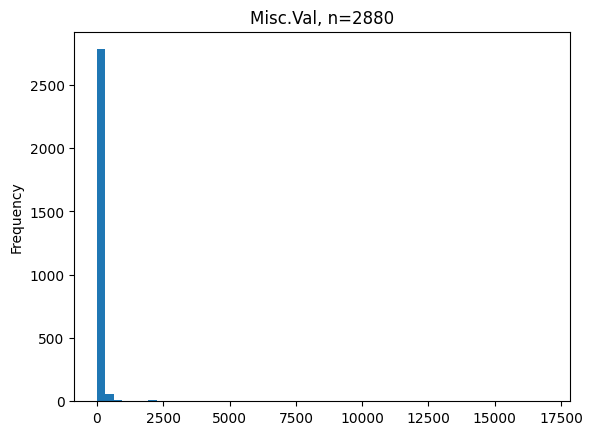

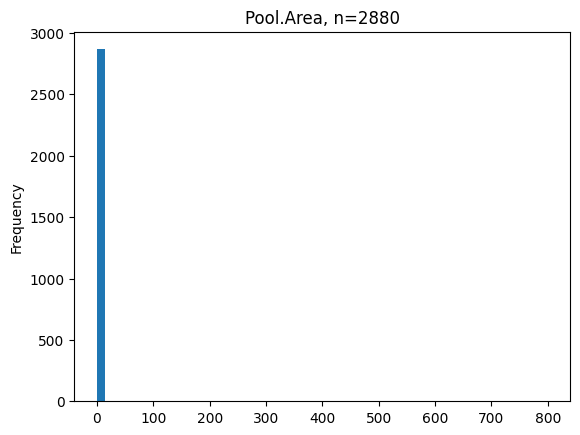

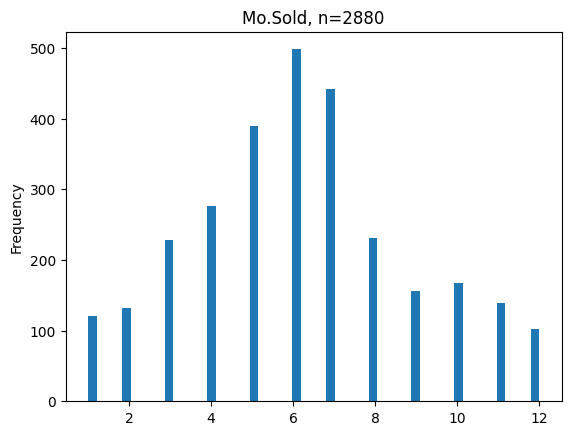

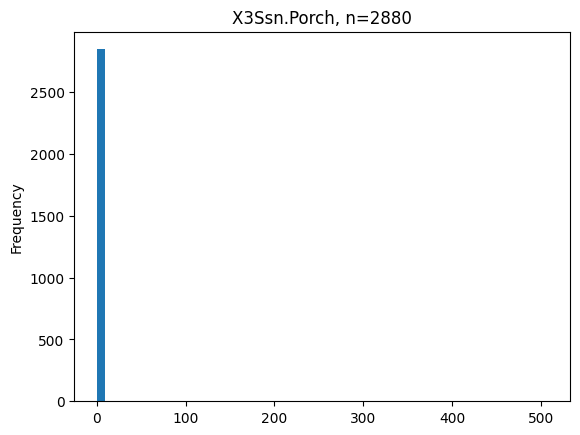

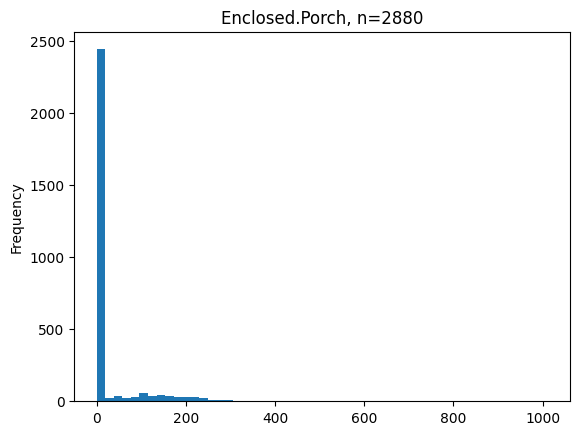

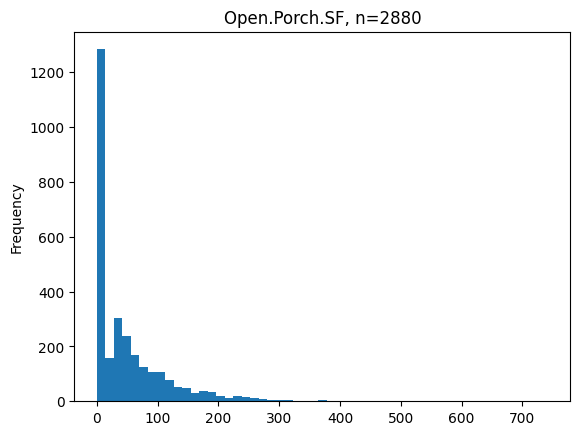

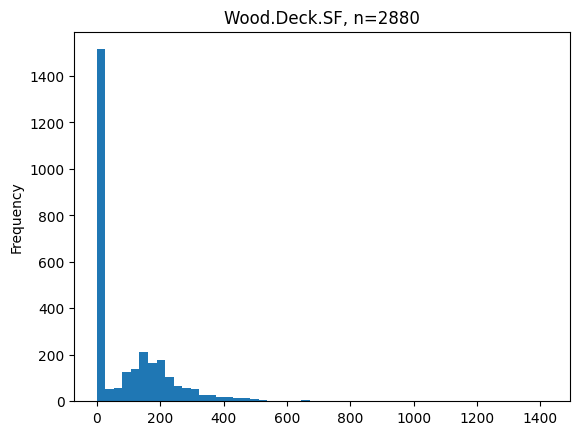

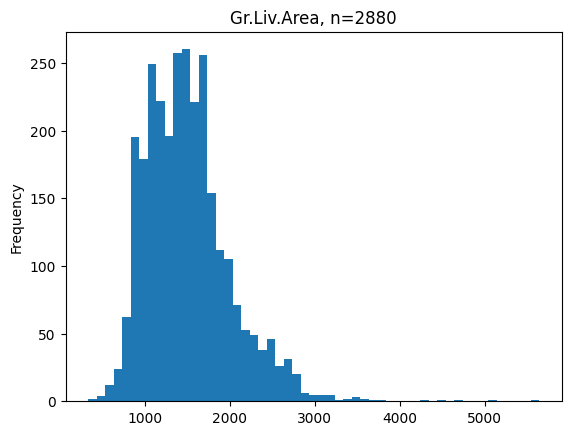

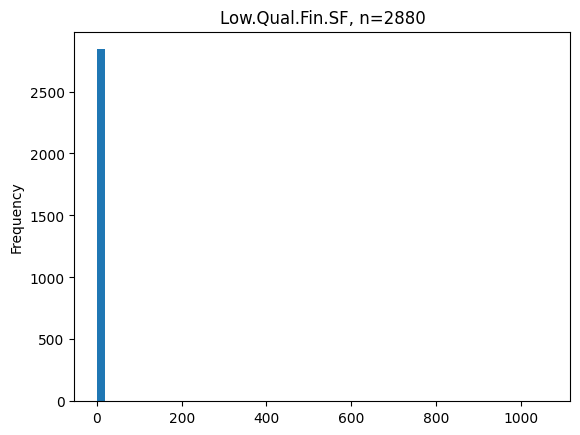

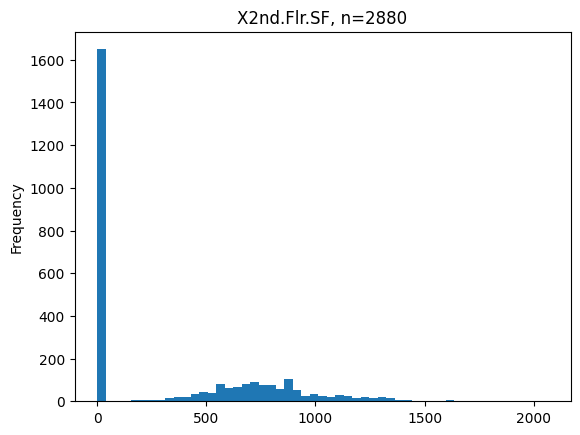

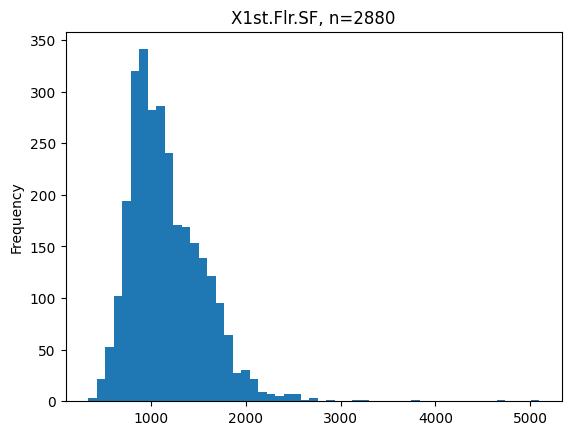

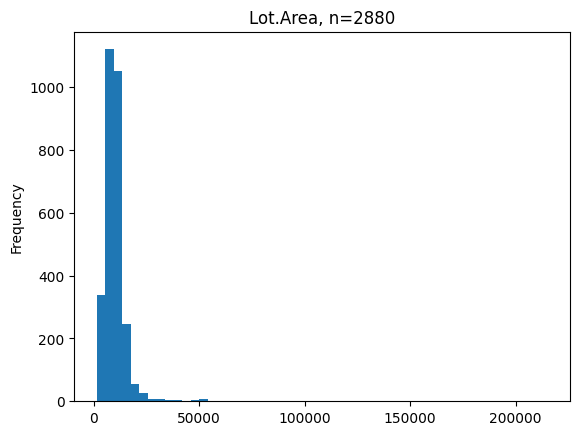

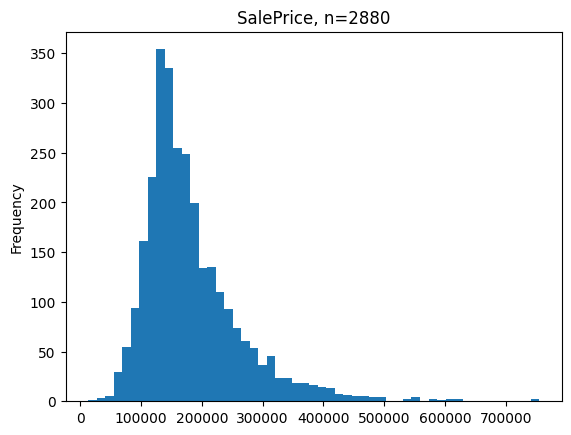

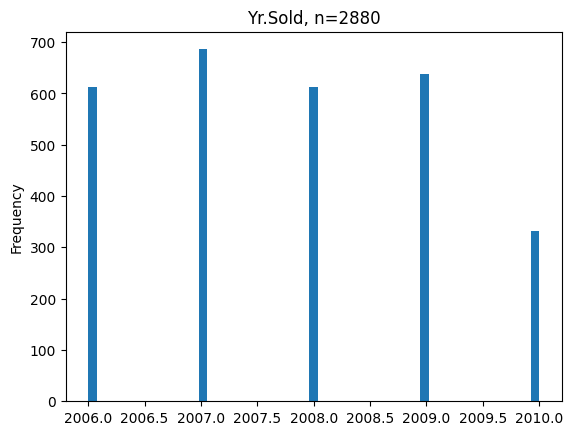

In [72]:
def plot_numericals(data, cols):
    summary = data[cols] \
        .describe() \
        .transpose() \
        .sort_values(by='count')

    print(summary)

    n = data.shape[0]
    b = int(np.sqrt(n))
    for k, (col, val) in enumerate(summary['count'].items()):
        plt.figure()
        data[col].plot.hist(bins=b)
        plt.title(f'{col}, n={int(val)}')
        plt.show()

plot_numericals(data, continuous_variables + discrete_variables)

#### `Garage.Yr.Blt` 

In [73]:
data['Garage.Yr.Blt'].describe()

count    2731.000000
mean     1978.341633
std        25.388716
min      1900.000000
25%      1960.000000
50%      1979.000000
75%      2002.000000
max      2207.000000
Name: Garage.Yr.Blt, dtype: float64

Oops! Looks like someone built a garage in the future!

The documentation states that the residential sales were collected from 2006 to 2010. We have the `Yr.Sold` variable to let us know when the house was sold. So we can obtain from those the information of how old the garage was when the house was sold! That is a better variable than `Garage.Yr.Blt` by itself.

In [74]:
garage_age = data['Yr.Sold'] - data['Garage.Yr.Blt']
garage_age.describe()

count    2731.000000
mean       29.443061
std        25.425924
min      -200.000000
25%         6.000000
50%        28.000000
75%        47.500000
max       110.000000
dtype: float64

Lets look at the garages "from the future"

In [75]:
data[garage_age < 0.0].transpose()

,2180,2260
MS.SubClass,20,20
MS.Zoning,RL,RL
Lot.Frontage,128.0,68.0
Lot.Area,39290.0,8298.0
Lot.Shape,IR1,IR1
Land.Contour,Bnk,HLS
Utilities,AllPub,AllPub
Lot.Config,Inside,Inside
Land.Slope,Gtl,Gtl
Neighborhood,Edwards,Timber


Only two rows. One is an obvious mistake, the other looks somewhat legitimate: house was sold new in 2007, garage was only finished in 2008. We can safely correct these errors, but if there was any doubt about the validity of fixing them, it is better to get rid of the rows. In our case we will set the garage age to zero.

In [76]:
garage_age[garage_age < 0.0] = 0.0

And now we remove the `Garage.Yr.Blt` column, replacing it with a new `Garage.Age` column.

In [77]:
data = data.drop(columns='Garage.Yr.Blt')
data['Garage.Age'] = garage_age

#### `Year.Remod.Add`, `Year.Built`

Lets apply the same age treatment to these variables

In [78]:
data[['Year.Remod.Add', 'Year.Built', 'Yr.Sold']].describe()

,Year.Remod.Add,Year.Built,Yr.Sold
count,2880.000000,2880.000000,2880.000000
mean,1984.514236,1971.773264,2007.788542
std,20.799105,30.012773,1.313914
min,1950.000000,1872.000000,2006.000000
25%,1966.000000,1954.000000,2007.000000
50%,1993.000000,1973.000000,2008.000000
75%,2004.000000,2001.000000,2009.000000
max,2010.000000,2010.000000,2010.000000


In [79]:
remod_age = data['Yr.Sold'] - data['Year.Remod.Add']
remod_age.describe()

count    2880.000000
mean       23.274306
std        20.792340
min        -2.000000
25%         4.000000
50%        15.000000
75%        42.000000
max        60.000000
dtype: float64

Oops, another weirdness, lets check

In [80]:
data[remod_age < 0.0].transpose()

,1702,2180,2181
MS.SubClass,60,20,60
MS.Zoning,RL,RL,RL
Lot.Frontage,134.0,128.0,130.0
Lot.Area,16659.0,39290.0,40094.0
Lot.Shape,IR1,IR1,IR1
Land.Contour,Lvl,Bnk,Bnk
Utilities,AllPub,AllPub,AllPub
Lot.Config,Corner,Inside,Inside
Land.Slope,Gtl,Gtl,Gtl
Neighborhood,NridgHt,Edwards,Edwards


Same story, lets set the remodeling age to zero for these cases

In [81]:
remod_age[remod_age < 0.0] = 0.0

In [82]:
house_age = data['Yr.Sold'] - data['Year.Built']
house_age.describe()

count    2880.000000
mean       36.015278
std        30.053254
min        -1.000000
25%         7.000000
50%        34.000000
75%        54.000000
max       136.000000
dtype: float64

Again...

In [83]:
data[house_age < 0.0].transpose()

,2180
MS.SubClass,20
MS.Zoning,RL
Lot.Frontage,128.0
Lot.Area,39290.0
Lot.Shape,IR1
Land.Contour,Bnk
Utilities,AllPub
Lot.Config,Inside
Land.Slope,Gtl
Neighborhood,Edwards


Same approach, lets set the age to zero in this case.

In [84]:
house_age[house_age < 0.0] = 0.0

In [85]:
data = data.drop(columns=['Year.Remod.Add', 'Year.Built'])
data['Remod.Age'] = remod_age
data['House.Age'] = house_age

#### Features that contain a lot of zeros

In the case of features that contain a lot of zeros, it could be that the feature contains actual information in some cases and zero to indicate that the feature is absent. Consider, for instance, the `Pool.Area` feature:

In [90]:
num_houses = data.shape[0]
num_houses_with_pool = data[data['Pool.Area'] > 0].shape[0]
print(f'Out of {num_houses} houses, only {num_houses_with_pool} have a pool.')

Out of 2880 houses, only 13 have a pool.


What to do? Discard the column? Discard the rows (we don't appraise houses with pools!)? Transform the column into a categorical `HasPool`?

Actually, it depends on the model. A linear model, for instance, can safely process this column: since the pool area for houses without pools is zero, the contribution of the pool area to the house price will be zero (remember that a linear model associates a multiplicative coefficient for each variable).

So we leave them all as is!